 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/classify_movie_reviews.ipynb#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1">Data preprocessing</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/classify_movie_reviews.ipynb#Create-the-model" data-toc-modified-id="Create-the-model-2">Create the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/classify_movie_reviews.ipynb#Training-model" data-toc-modified-id="Training-model-3">Training model</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/classify_movie_reviews.ipynb#Putting-things-together" data-toc-modified-id="Putting-things-together-4">Putting things together</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/classify_movie_reviews.ipynb#Compare-different-models" data-toc-modified-id="Compare-different-models-5">Compare different models</a></span></li></ul></div>

# Feed-forward neural network on classifying movie reviews 

This notebook creates a feed-forward neural network in Keras to classify movie reviews into 'good' (1) or 'bad' (0) class. It contains the steps of model creation, training, visualization of learning through epochs, model testing, and some model comparisons using different hyper-parameters.

In [77]:
import numpy as np
from keras.datasets import imdb
from keras import models
from keras import layers
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

The movie reviews dataset is built-in into keras..

In [19]:
(train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = imdb.load_data(num_words=10000)

# Print out the number of samples in training and test sets
print(train_x_orig.shape)
print(train_y_orig.shape)

(25000,)
(25000,)


In general I'd use a different split with more samples in the training set and less in the test, like 70-30 instead of 50-50, but let's keep it like this for now. Later on, I'll use a small portion of the training set as a 'development' / 'validation' set.

The input data (with "\_x") contains sequences of words used in movie reviews. The words are actually mapped to numbers from 0 to 9999 (because we're keeping only the 10000 most frequent words). The output data (with "\_y") contains a binary target value of "1" or "0", denoting respectively positive and negative movie review.

Actual English words can be mapped back from numbers using the `imdb.get_word_index()` method, which returns a dictionary for the mapping.

In [20]:
word_index = imdb.get_word_index()

# Print out a few entries
print(list(word_index.items())[:5])

[('fawn', 34701), ('tsukino', 52006), ('nunnery', 52007), ('sonja', 16816), ('vani', 63951)]


In [21]:
# Create a reverse dictionary
reverse_word_index = dict([(y, x) for x, y in word_index.items()])

# Print out a few entries
print(list(reverse_word_index.items())[:5])

[(34701, 'fawn'), (52006, 'tsukino'), (52007, 'nunnery'), (16816, 'sonja'), (63951, 'vani')]


The following method `decode_review` will be used to convert a movei review given in numbers into words.

In [22]:
def decode_review(review_in_numbers):

    # the indices are offset by 3, if a word is not in most frequent 10000 return a '?'
    return ' '.join([reverse_word_index.get(i-3, '?') for i in review_in_numbers])

# An example
print("Review with score %d: %s" % (train_y_orig[20], decode_review(train_x_orig[20])))

Review with score 0: ? shown in australia as ? this incredibly bad movie is so bad that you become ? and have to watch it to the end just to see if it could get any worse and it does the storyline is so predictable it seems written by a high school ? class the sets are pathetic but ? better than the ? and the acting is wooden br br the ? ? seems to have been stolen from the props ? of ? ? there didn't seem to be a single original idea in the whole movie br br i found this movie to be so bad that i laughed most of the way through br br malcolm mcdowell should hang his head in shame he obviously needed the money


## Data preprocessing

Keeping words represented as integer numbers and feeding them to a neural network is not a good idea. This is simply because we don't want to use numerical values that can be ordered, such that number(word1) could be larger/smaller than number(word2). The solution is to one-hot encode the word sequences. The encoded entries will have a dimension (num_samples, 10000).

In [23]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an empty matrix
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # Pass a list `sequence` of words in the reveiew for which the encoding is 1
        results[i, sequence] = 1
    return results

train_x = vectorize_sequences(train_x_orig)
test_x = vectorize_sequences(test_x_orig)
print(train_x.shape)
print(test_x.shape)

(25000, 10000)
(25000, 10000)


Also convert target values into numpy arrays..

In [16]:
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

It would also be useful to have a development/validation set which will be used for hyperparameter optimization. I'll extract 10000 samples from the training set for this.

In [30]:
dev_x = train_x[:10000]
train_x_partial = train_x[10000:]
dev_y = train_y[:10000]
train_y_partial = train_y[10000:]

## Create the model

We'll use a standard feed-forward neural network (`Sequential` model) with two hidden layers, and we'll feed the one-hot encodings of the input words to it. The activation function is chosen as `relu` as a suitable choice for many applications. The activation in the output layer is chosen as `sigmoid` so its outputs probability in the range [0,1] is easy to convert to binary output {0, 1}.

Although we use a feed-forward neural net model in this case, it might be more suitable to use a recurrent one, such as an LSTM, which would be able to catch information from the word sequence. For example 'not good' phrase instead of ['not' 'good'].

We'll also choose an optimizer and a loss function. `rmsprop` is an improvement of the standard gradient descent, while `binary_crossentropy` is chosen because we have a binary output. The 'corssentropy' would measure the distance between the distribution of predictions and distribution of actual values. The `accuracy` metric would just give the percentage of correctly predicted outputs (0 or 1) out of all tried predictions.

In [85]:
def create_model(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'], activation='relu'):
    
    # Create a sequential model and stack layers one after another
    model = models.Sequential()
    model.add(layers.Dense(16, activation=activation, input_shape=(10000,)))
    model.add(layers.Dense(16, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # The following way could also be used.. It allows to specify the parameters of the optimizer, or use a custom optimizer/loss/metric
    # model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    
    return model

## Training model

Let's train the model for a small number of epochs and some batch_size. I don't think that the `batch_size` selection could influence our results if we have large enough number of iterations (it should only influence the speed at which we get to our results), but maybe I'm wrong. It's nice that we can plug the validation data during training too, so we can monitor the performance during training on both train and dev sets.

In [65]:
def train_model(model, train_x, train_y, dev_x, dev_y, epochs=20, batch_size=512):
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(dev_x, dev_y))
    return history

The `History` object returned by the `fit` method contains information on the training and validation losses, and metrics. Let's plot them.

In [68]:
def plot_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(train_loss) + 1)

    plt.rcParams['figure.figsize'] = (8, 10)
    fig, ax = plt.subplots(ncols=1, nrows=2, sharex=False, sharey=False)

    ax[0].plot(epochs, train_loss, 'o-', label='Training')
    ax[0].plot(epochs, val_loss, 'o-', label='Validation')
    ax[0].set_title('Training and validation loss & accuracy')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(epochs, train_acc, 'o-', label='Training')
    ax[1].plot(epochs, val_acc, 'o-', label='Validation')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.show()

In [75]:
def test_model(model, test_x, test_y):
    results = model.evaluate(test_x, test_y)
    print("Loss on test set: %.3f" % results[0])
    print("Accuracy on test set: %.3f%%" % (100 * results[1]))
    return results

## Putting things together

Now let's stack together the methods created: model creation, training, testing and visualization of history.

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 161us/step - loss: 0.5091 - acc: 0.7838 - val_loss: 0.3968 - val_acc: 0.8497
Epoch 2/20
15000/15000 [==============================] - 2s 141us/step - loss: 0.3040 - acc: 0.9013 - val_loss: 0.3044 - val_acc: 0.8887
Epoch 3/20
15000/15000 [==============================] - 2s 142us/step - loss: 0.2240 - acc: 0.9277 - val_loss: 0.2811 - val_acc: 0.8897
Epoch 4/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.1748 - acc: 0.9450 - val_loss: 0.2819 - val_acc: 0.8876
Epoch 5/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.1408 - acc: 0.9555 - val_loss: 0.2829 - val_acc: 0.8867
Epoch 6/20
15000/15000 [==============================] - 2s 133us/step - loss: 0.1149 - acc: 0.9645 - val_loss: 0.2984 - val_acc: 0.8854
Epoch 7/20
15000/15000 [==============================] - 2s 130us/step - loss: 0.0938 - acc: 0.9714 - val_loss: 0.3279 - 

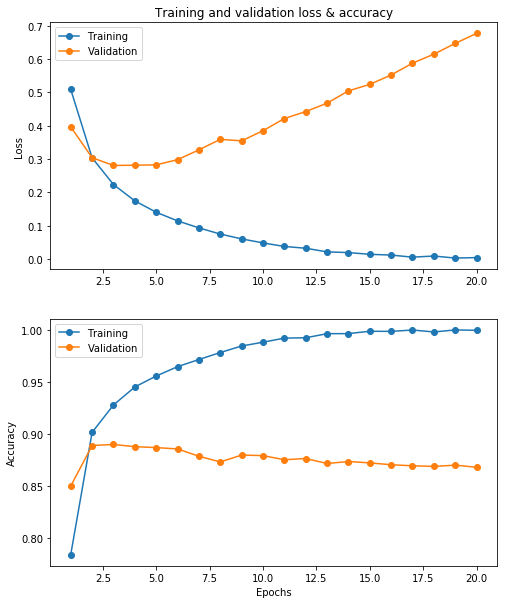

25000/25000 [==============================] - 2s 95us/step
Loss on test set: 0.738
Accuracy on test set: 85.476%


In [84]:
model = create_model()
history = train_model(model, train_x_partial, train_y_partial, dev_x, dev_y)
plot_history(history)
results = test_model(model, test_x, test_y)

From the above figures we can observe that the network starts overfitting to the training set after the 4 epoch. One way to fight with this is 'early stoping' - simply stop training in the minimum of the validation curve. But this is not the best solution. Better solutions would be to use some regularization mechanism, such as L1/L2 regularization, dropout etc. In this case I won't use regularization - the focus is now on playing with the hyperparameters we've used.

## Compare different models

It would be interesting to compare models with different hyper-parameters, for example: changing the epochs, activation functions, optimizers, losses etc. This would help in understanding how different things work.

**Question 1**: Will early stopping in the 4-th epoch really produce a better model? 

In [83]:
# Re-create the same model, only changing the epochs parameter
model_4epochs = create_model()
history_4epochs = train_model(model_4epochs, train_x_partial, train_y_partial, dev_x, dev_y, epochs=4, batch_size=512)
results_4epochs = test_model(model_4epochs, test_x, test_y)

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 2s 165us/step - loss: 0.5773 - acc: 0.6805 - val_loss: 0.4671 - val_acc: 0.8286
Epoch 2/4
15000/15000 [==============================] - 3s 174us/step - loss: 0.3686 - acc: 0.8944 - val_loss: 0.3400 - val_acc: 0.8851
Epoch 3/4
15000/15000 [==============================] - 2s 157us/step - loss: 0.2544 - acc: 0.9239 - val_loss: 0.2976 - val_acc: 0.8871
Epoch 4/4
25000/25000 [==============================] - 2s 90us/step
Loss on test set: 0.295
Accuracy on test set: 88.348%


**Answer 1**: Yes, it improved the accuracy on the test set from ~85.5% to ~88.3%. It also drastically improved the Test loss from 0.74 to 0.29. Not sure why such big improvement..

**Question 2**: I guess Adam optimizer is better than RMSprop, will it improve results?

In [88]:
model_4epochs_adam = create_model(optimizer='adam')
history_4epochs_adam = train_model(model_4epochs_adam, train_x_partial, train_y_partial, dev_x, dev_y, epochs=4, batch_size=512)
results_4epochs_adam = test_model(model_4epochs_adam, test_x, test_y)

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 3s 187us/step - loss: 0.5976 - acc: 0.7417 - val_loss: 0.4734 - val_acc: 0.8473
Epoch 2/4
15000/15000 [==============================] - 2s 141us/step - loss: 0.3707 - acc: 0.8867 - val_loss: 0.3359 - val_acc: 0.8799
Epoch 3/4
15000/15000 [==============================] - 2s 143us/step - loss: 0.2522 - acc: 0.9196 - val_loss: 0.2920 - val_acc: 0.8869
Epoch 4/4
25000/25000 [==============================] - 2s 93us/step
Loss on test set: 0.294
Accuracy on test set: 88.204%


**Answer 2**: I run the above code a few times, since results are different on each run (I guess this is because of random selection of batches - internal to Keras), and got pretty similar results as with RMSprop. I wouldn't draw any conclusion here, mainly because it's a very small model with only 4 epochs. Anyway, comparisons on bigger projects out of this work showed improvement when using Adam - reaching lower loss on the validation set than RMSprop.